# Go "Birding" with Google Street View?
***Virtual Field Survey Workflow Showcase of Sandhill Cranes and Their Habitats in North America***

Geospatial Data Science Project - Part 3: This notebook documents the workflow for Google Street View 'Birding,' which encompasses processes such as sample retrieval, Google Street View metadata and image downloads, and more.

By ZJ Zhou (zhijiez2@illinois.edu)

## Notebook Outline:
- [Environmental Setup](#ES)
- [Working Directory Check](#WDC)
- [Data Preparation](#DPre)
- [Explorative Analysis & Visualizations](#EAV)
- [Clustering Analysis](#CA)
- [Random Sampling for Each Cluster Group](#RSECG)
- [Land Cover Information for Sampled Observations Based on Cropland Data Layer](#LCISOBCDL)
- [Google Street View Fetching for Sampled Observations](#GSVFSO)

<a id='ES'></a>
## Environment Setup

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from shapely.geometry import Point
!pip install streetview
from streetview import search_panoramas, get_panorama_meta, get_panorama
!pip install earthengine-api
!pip install geemap
import geemap
from pathlib import Path
import os
import ee
import glob
import csv

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


<a id='WDC'></a>
## Working Directory Check

In [2]:
# Create a Path object for the current directory
current_directory = Path.cwd()

# Get the parent directory
parent_directory = current_directory.parent

print("Current Directory:", current_directory)
print("Parent Directory:", parent_directory)

Current Directory: /home/jovyan/work/GGIS407_23Fall/Project
Parent Directory: /home/jovyan/work/GGIS407_23Fall


<a id='DPre'></a>
## Data Preparation

In [3]:
# Read CSV file into a pandas DataFrame
df = pd.read_csv('observations-360459.csv')

# Convert the "observed_on" column to a datetime data type
df['observed_on'] = pd.to_datetime(df['observed_on'])

# Extract the year and month
df['year'] = df['observed_on'].dt.year
df['month'] = df['observed_on'].dt.month

# Get the basic summary information of the dataset
# df.info()

# Filter out observation records without valid latitude or longitude entries
# also, we filter out those without valid observed time entries OR dated before the year of 2008 
# Google Street View images are not available before the year of 2008
filtered_df = df[df['latitude'].notna() & df['longitude'].notna() & df['observed_on'].notna() & (df['year'] >= 2008)] 

# Filter out observation records outside of North America
filtered_df = filtered_df[(filtered_df['place_country_name'] == 'United States') |
                          (filtered_df['place_country_name'] == 'Canada') |
                          (filtered_df['place_country_name'] == 'Mexico')]

print(f'In total, we have {str(len(filtered_df))} observation records of Sandhill Cranes across the North America since 2008!!!')

In total, we have 38559 observation records of Sandhill Cranes across the North America since 2008!!!


### Overview (Map)

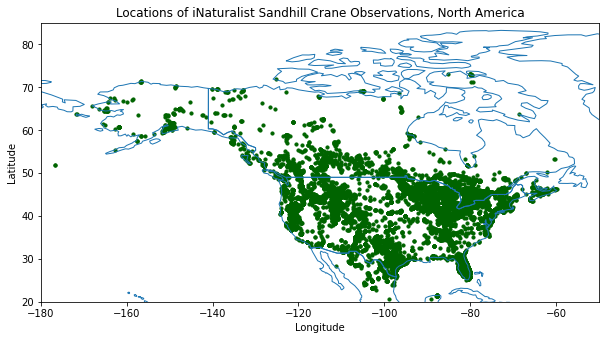

In [4]:
# Define the bounding box coordinates for North America in WGS 84
north_america_bbox = (-180, 20, -50, 85)  # (minx, miny, maxx, maxy)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Set the extent of the plot to the North America bounding box in WGS 84
ax.set_xlim(north_america_bbox[0], north_america_bbox[2])
ax.set_ylim(north_america_bbox[1], north_america_bbox[3])

# Build geopandas dataframe for mapping
gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude))
world.boundary.plot(ax=ax, linewidth=1)
gdf.plot(ax=ax, color='darkgreen', markersize=10)
plt.title('Locations of iNaturalist Sandhill Crane Observations, North America')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<a id='EAV'></a>
## Explorative Analysis & Visualizations

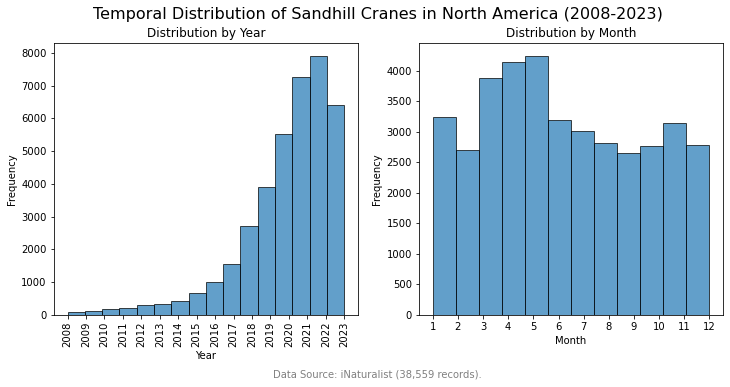

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the distribution by year
unique_years =  filtered_df['year'].unique()
axes[0].hist(filtered_df['year'], bins=len(unique_years), edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution by Year')
axes[0].set_xticks(filtered_df['year'].unique())
axes[0].set_xticklabels(filtered_df['year'].unique(), rotation=90, ha="center")

# Plot the distribution by month
unique_months =  filtered_df['month'].unique()
axes[1].hist(filtered_df['month'], bins=len(unique_months), edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution by Month')
axes[1].set_xticks(filtered_df['month'].unique())
fig.suptitle('Temporal Distribution of Sandhill Cranes in North America (2008-2023)\n', fontsize=16)
# plt.tight_layout()
# Add a caption below the plots
caption = "Data Source: iNaturalist (38,559 records)."
plt.figtext(0.5, -0.05, caption, ha="center", fontsize=10, color='grey')
plt.show()

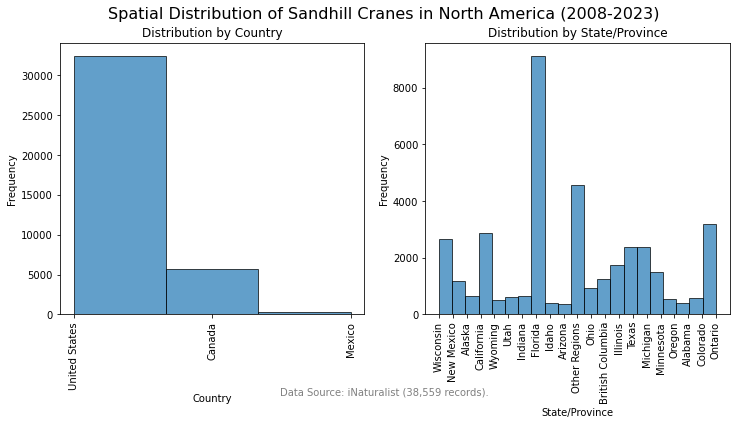

In [6]:
# Combine region info for visualization purpose
top_20_states = filtered_df['place_admin1_name'].value_counts().head(20).index.tolist()
# Replace state names not in the top 20 with "Other Regions"
temp_state_viz = filtered_df
temp_state_viz.loc[~temp_state_viz['place_admin1_name'].isin(top_20_states), 'place_admin1_name'] = "Other Regions"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the distribution by country
unique_countries = filtered_df['place_country_name'].unique()
axes[0].hist(filtered_df['place_country_name'], bins=len(unique_countries), edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution by Country')
axes[0].set_xticks(filtered_df['place_country_name'].unique())
axes[0].set_xticklabels(unique_countries, rotation=90, ha="center")

# Plot the distribution by state/province
unique_regions = temp_state_viz['place_admin1_name'].unique()
axes[1].hist(temp_state_viz['place_admin1_name'], bins=len(unique_regions), edgecolor='black', alpha=0.7)
axes[1].set_xlabel('State/Province')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution by State/Province')
axes[1].set_xticks(unique_regions)
axes[1].set_xticklabels(unique_regions, rotation=90, ha="center")

fig.suptitle('Spatial Distribution of Sandhill Cranes in North America (2008-2023)\n', fontsize=16)
# plt.tight_layout()
# Add a caption below the plots
caption = "Data Source: iNaturalist (38,559 records)."
plt.figtext(0.5, -0.1, caption, ha="center", fontsize=10, color='grey')
plt.show()

<a id='CA'></a>
## Clustering Analysis

In [7]:
# Extract coordinates for spatial clustering purpose
coordinates = list(zip(filtered_df['latitude'], filtered_df['longitude']))

# Set the number of clusters as 10
num_clusters = 10
kmeans = KMeans(num_clusters) 

# Perform the kmeans clustering algorithm
clusters = kmeans.fit_predict(coordinates)

# print(clusters)

# Add the cluster labels to the original DataFrame
filtered_df['Cluster'] = clusters

<a id='RSECG'></a>
## Random Sampling for Each Cluster Group

In [8]:
# Define the number of samples per cluster
samples_per_cluster = 100

# Group the DataFrame by 'Cluster' and sample within each group
# Note that if we would like to reproduce the same results, keep a specific random_state parameter for reproducibility
sampled_df = filtered_df.groupby('Cluster').apply(lambda group: group.sample(samples_per_cluster, random_state = 999))

# Reset the index
sampled_df = sampled_df.reset_index(drop=True)

# sampled_df
# sampled_df.columns

print(f"We have successfully extracted {str(len(sampled_df))} samples from our clustered observation records!")

We have successfully extracted 1000 samples from our clustered observation records!


<a id='LCISOBCDL'></a>
## Land Cover Information for Sampled Observations Based on Cropland Data Layer

### Generate 100-meter Buffers for Each Sampled Point

In [9]:
# Set Buffer Directory
buffer_dir = os.path.normpath(f"{current_directory}/sampled_buffers")
if not os.path.exists(buffer_dir):
    os.mkdir(buffer_dir)
    
# Create a GeoDataFrame based on sampled_df
sampled_gdf = gpd.GeoDataFrame(sampled_df, geometry=gpd.points_from_xy(sampled_df.longitude, sampled_df.latitude))
# Specify WGS84 as the reference coordinate system for our sampled dataset 
sampled_gdf = sampled_gdf.set_crs('EPSG:4326')
# Reproject it Web Mercator (in meters)
sampled_gdf = sampled_gdf.to_crs('EPSG:3857')

# Set buffer size in meters
buffer_size = 100

# Create an empty GeoDataFrame for the buffers to be generated
sampled_buffer_gdf = gpd.GeoDataFrame(columns=['id','geometry', 'year'])

# Generate buffers for the GeoDataFrame
buffer_size = 100  # Buffer size in meters

# Set the column entries of buffer dataset
sampled_buffer_gdf['id'] = sampled_gdf['id']
sampled_buffer_gdf['year'] = sampled_gdf['year']
sampled_buffer_gdf['geometry'] = sampled_gdf['geometry'].buffer(buffer_size)

# Save buffers by year
for YEAR in range(2013, 2024):
    
    # Define the output shapefile name
    output_buffer = os.path.normpath(f"{buffer_dir}/sampled_buffer_{YEAR}.shp")  
    
    buffer_gdf = sampled_buffer_gdf[sampled_buffer_gdf['year'] == YEAR]

    # Save generated buffers in the specified directory (for back up purposes)
    buffer_gdf.to_file(output_buffer, driver='ESRI Shapefile')

### Use geemap to Calculate the Crop Type Area Ratio for Each Buffer

In [10]:
# To use geemap or any other Google Earth Engine related features in python, we need to authenticate it first.
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AfJohXm1Q2OIsWUh6yS1wa_hkd8jaAgs6fcbsbITq1gIO8I-MQlMQQxggm4



Successfully saved authorization token.


In [11]:
for YEAR in range(2013, 2024):
    
    # Specify the buffer storage path 
    output_buffer = os.path.normpath(f"{buffer_dir}/sampled_buffer_{YEAR}.shp")  
    
    # Convert our shapefile to ee (Earth Engine) objects
    buffer = geemap.shp_to_ee(output_buffer)
    
    # Note that since the 2023 CDL have not be published yet, we use the 2022 CDL as a proxy
    if YEAR == 2023:
        dataset = ee.Image("USDA/NASS/CDL/" + str(2022))
    else:
        dataset = ee.Image("USDA/NASS/CDL/" + str(YEAR))
    
    # Select the corresponding band in CDL dataset for crop type information
    cropland = ee.Image(dataset.select('cropland'))
    
    # Set up the path for CDL statistics output
    cdl_stats = os.path.normpath(f'{current_directory}/cdl_stats_{YEAR}.csv')
    
    # Use zonal_statistics_by_group to calculate the area ratio of each crop type within each buffer
    # statistics_type can be either 'SUM' or 'PERCENTAGE'
    # denominator can be used to convert square meters to other areal units, such as square kilometers
    geemap.zonal_statistics_by_group(
        cropland.clip(buffer),
        buffer,
        cdl_stats,
        statistics_type='PERCENTAGE',
        #denominator=1000000,
        #decimal_places=2,
    )

Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/work/GGIS407_23Fall/Project/cdl_stats_2013.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/work/GGIS407_23Fall/Project/cdl_stats_2014.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/work/GGIS407_23Fall/Project/cdl_stats_2015.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/work/GGIS407_23Fall/Project/cdl_stats_2016.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/work/GGIS407_23Fall/Project/cdl_stats_2017.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/work/GGIS407_23Fall/Project/cdl_stats_2018.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/work/GGIS407_23Fall/Project/cdl_stats_2019.csv
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/work/GGIS407_23

In [12]:
# Use the glob module to get a list of CSV file paths in a directory.
file_paths = glob.glob('cdl_stats_*')

# Create an empty list to store DataFrames, one for each CSV file
dataframes = []

# Read each CSV file into a DataFrame and append it to the list of DataFrames
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate the DataFrames vertically to merge them while retaining all columns
merged_df = pd.concat(dataframes, ignore_index=True)

# Fill missing values (empty entries) with 0
merged_df.fillna(0, inplace=True)

# Replace 'column_to_remove' with the name of the column you want to remove
column_to_remove = 'system:index'
if column_to_remove in merged_df.columns:
    merged_df.drop(columns=[column_to_remove], inplace=True)
column_to_remove = 'Class_sum'
if column_to_remove in merged_df.columns:
    merged_df.drop(columns=[column_to_remove], inplace=True)

# Save the merged DataFrame to a new CSV file if needed
merged_df.to_csv('merged_file.csv', index=False)

In [13]:
merged_df.columns

Index(['Class_61', 'Class_190', 'Class_195', 'Class_141', 'Class_152',
       'Class_21', 'Class_123', 'Class_36', 'Class_131', 'Class_142',
       'Class_121', 'Class_176', 'Class_124', 'Class_1', 'Class_3', 'Class_5',
       'id', 'year', 'Class_111', 'Class_122', 'Class_24', 'Class_37',
       'Class_212', 'Class_2', 'Class_4', 'Class_76', 'Class_33', 'Class_23',
       'Class_112', 'Class_143', 'Class_6', 'Class_41', 'Class_42', 'Class_69',
       'Class_75', 'Class_205', 'Class_28', 'Class_216', 'Class_59',
       'Class_217'],
      dtype='object')

In [14]:
# Load the CSV file containing the crop mapping
codebook_df = pd.read_csv('CDL_crop_codebook.csv')

# Create a custom mapping dictionary from the codebook DataFrame
custom_mapping = dict(zip(codebook_df['Codes'], codebook_df['Class_Names']))

# Iterate through the DataFrame's column names
for col_name in merged_df.columns:
    if (col_name != 'id') & (col_name != 'year'):

        # Extract the numerical part from the column name
        num = int(col_name.split('_')[1])

        # Look up the corresponding crop name from the custom mapping
        if num in custom_mapping:
            crop_name = custom_mapping[num]
            merged_df.rename(columns={col_name: crop_name}, inplace=True)

In [15]:
merged_df.columns

Index(['Fallow/Idle Cropland', 'Woody Wetlands', 'Herbaceous Wetlands',
       'Deciduous Forest', 'Shrubland', 'Barley', 'Developed/Med Intensity',
       'Alfalfa', 'Barren', 'Evergreen Forest', 'Developed/Open Space',
       'Grass/Pasture', 'Developed/High Intensity', 'Corn', 'Rice', 'Soybeans',
       'id', 'year', 'Open Water', 'Developed/Low Intensity', 'Winter Wheat',
       'Other Hay/Non Alfalfa', 'Oranges', 'Cotton', 'Sorghum', 'Walnuts',
       'Safflower', 'Spring Wheat', 'Perennial Ice/Snow ', 'Mixed Forest',
       'Sunflower', 'Sugarbeets', 'Dry Beans', 'Grapes', 'Almonds',
       'Triticale', 'Oats', 'Peppers', 'Sod/Grass Seed', 'Pomegranates'],
      dtype='object')

In [16]:
merged_df

,Fallow/Idle Cropland,Woody Wetlands,Herbaceous Wetlands,Deciduous Forest,Shrubland,Barley,Developed/Med Intensity,Alfalfa,Barren,Evergreen Forest,...,Sunflower,Sugarbeets,Dry Beans,Grapes,Almonds,Triticale,Oats,Peppers,Sod/Grass Seed,Pomegranates
0,0.0,0.851855,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,1.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,0.0,0.000000,0.000000,0.0,1.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
964,0.0,0.942866,0.057134,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
965,0.0,0.000000,0.236111,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
966,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Example: Getting all Points with >50% Corn

In [17]:
corn_df = merged_df[merged_df['Corn'] > 0.5]
print(f"We got {len(corn_df)} points with larger than 50% of its 100-meter buffer covered by corn in our sample!!!")

We got 24 points with larger than 50% of its 100-meter buffer covered by corn in our sample!!!


In [18]:
corn_df['id'].tolist()

[4373626,
 10747177,
 17932911,
 146770529,
 147172132,
 151970324,
 180432061,
 144993828,
 142121284,
 119643906,
 109229187,
 113250058,
 141789316,
 21407838,
 8919418,
 69743841,
 103853866,
 68025771,
 103937493,
 82995323,
 73540094,
 41257012,
 43245038,
 44267370]

In [19]:
joined_corn_df = pd.merge(corn_df['id'], filtered_df, on='id')

In [20]:
joined_corn_df[['id','observed_on','latitude','longitude']]

,id,observed_on,latitude,longitude
0,4373626,2016-10-15,38.147981,-121.457291
1,10747177,2018-04-08,46.996799,-119.587029
2,17932911,2018-10-28,38.745567,-108.135105
3,146770529,2023-01-17,38.207037,-121.503203
4,147172132,2023-01-21,38.206757,-121.504154
5,151970324,2023-03-21,43.036608,-112.481733
6,180432061,2023-08-27,38.891274,-87.134136
7,144993828,2022-12-23,38.197551,-121.501237
8,142121284,2022-11-13,38.160591,-121.476371
9,119643906,2022-05-30,40.221247,-111.707807


In [21]:
# Convert values from two columns to lists
lat_list = joined_corn_df['latitude'].values.tolist()
lon_list = joined_corn_df['longitude'].values.tolist()
List_coord = list(zip(lat_list, lon_list))

In [22]:
List_coord

[(38.1479810716, -121.4572906494),
 (46.9967990222, -119.5870287034),
 (38.745567, -108.135105),
 (38.2070368747, -121.5032030789),
 (38.2067568135, -121.5041537504),
 (43.0366083333, -112.4817333333),
 (38.8912740294, -87.1341360773),
 (38.1975511174, -121.5012371103),
 (38.1605905419, -121.4763713378),
 (40.2212469, -111.7078073),
 (44.6887559587, -92.9629791467),
 (44.6887903001, -92.9657239561),
 (34.9379556365, -106.0564966812),
 (42.4579083333, -89.1181333333),
 (33.7050387545, -80.5015014287),
 (38.2126693424, -121.5012868844),
 (38.1719167, -121.51259327),
 (38.1643617, -121.5163415),
 (38.1574892772, -121.4656373089),
 (45.280931488, -92.814049077),
 (45.5447747988, -93.8609251621),
 (43.7564685844, -116.9876991212),
 (44.0414864328, -92.5631665438),
 (41.0837329679, -96.2451140081)]

<a id='GSVFSO'></a>
## Google Street View Fetching

### Function: downloadGSVMetaData(LIST_COORDINATES, TASK)

In [23]:
def downloadGSVMetaData(LIST_COORDINATES, TASK):

    """
    Downloads Google Street View metadata for a list of coordinates.

    Parameters:
    - LIST_COORDINATES (list of tuples): A list of latitude and longitude coordinates to search for GSV imagery.
    - TASK (str): A task identifier to be used in the generated metadata CSV file name.

    This function searches for GSV imagery around the provided coordinates and saves metadata to a CSV file.
    """
    
    # Generate the file path for the metadata CSV file
    path = os.path.normpath("GSV_METADATA_{}.csv".format(TASK))
    
    # Open the metadata CSV file for appending
    metadata = open(path, "a")
    
    # Create a CSV writer object with newline terminator
    writer = csv.writer(metadata, lineterminator='\n')
    
    # Write the header row to the CSV file
    writer.writerow(['ID', 'Panoid', 'Lat', 'Lon', 'Heading', 'Pitch', 'Roll', 'Year', 'Month']) 
    
    # Initialize an index
    index = 0
    
    # Iterate through the list of coordinates (LAT, LON)
    for LAT, LON in LIST_COORDINATES:
        try:
            # Use the search_panoramas function to get panorama information
            panoids = search_panoramas(lat=LAT, lon=LON)
        except:
            # Handle errors if the search_panoramas function fails
            print("Index out of range error at lat={}, lon={}: no GSV imagery in this area.".format(LAT, LON))
        print("Searching GSV Images around...({}, {})".format(LAT, LON))
        if len(panoids)>0: 
            for id in range(len(panoids)):
                if panoids[id].date:
                    year = int(panoids[id].date[:4])
                    month= int(panoids[id].date[5:])
                    index += 1
                    metadata = open(path, "a")
                    writer = csv.writer(metadata, lineterminator = '\n')
                    writer.writerow([index, panoids[id].pano_id,panoids[id].lat,panoids[id].lon,panoids[id].heading,panoids[id].pitch, panoids[id].roll,year,month])
                    print(index)  

        else:
            print('no GSV imagery found in this area')
            continue

In [24]:
downloadGSVMetaData(List_coord, 'CORN')

Searching GSV Images around...(38.1479810716, -121.4572906494)
no GSV imagery found in this area
Searching GSV Images around...(46.9967990222, -119.5870287034)
no GSV imagery found in this area
Searching GSV Images around...(38.745567, -108.135105)
no GSV imagery found in this area
Searching GSV Images around...(38.2070368747, -121.5032030789)
Searching GSV Images around...(38.2067568135, -121.5041537504)
no GSV imagery found in this area
Searching GSV Images around...(43.0366083333, -112.4817333333)
no GSV imagery found in this area
Searching GSV Images around...(38.8912740294, -87.1341360773)
no GSV imagery found in this area
Searching GSV Images around...(38.1975511174, -121.5012371103)
no GSV imagery found in this area
Searching GSV Images around...(38.1605905419, -121.4763713378)
no GSV imagery found in this area
Searching GSV Images around...(40.2212469, -111.7078073)
no GSV imagery found in this area
Searching GSV Images around...(44.6887559587, -92.9629791467)
no GSV imagery fo

In [25]:
gsv_df = pd.read_csv('GSV_METADATA_CORN.csv').drop_duplicates()
gsv_df

,ID,Panoid,Lat,Lon,Heading,Pitch,Roll,Year,Month
0,ID,Panoid,Lat,Lon,Heading,Pitch,Roll,Year,Month
1,1,YdyDug5KipDP88_g3LlzcA,38.2613558375869,-121.4406002341907,169.7516479492188,93.66971588134766,0.8723912239074707,2007,6
2,2,zjOWG3903_sas4CstIlUWg,38.26135944130262,-121.440610609495,169.9563446044922,88.99956512451172,1.432158350944519,2015,8
3,3,3kA8skjnYcwFXRB4WofR8w,38.26133969218689,-121.4406068604355,169.4710083007812,89.78001403808594,1.364865064620972,2016,11
4,4,5lZ2CQ6r13vrIyEE1fB9CA,30.62476293717697,-97.39541297004071,341.0656433105469,94.39850616455078,1.765115857124329,2008,2
5,5,4v3QNsEpA7dGAcmNV77-tg,30.62476069881489,-97.39543697001042,156.5848693847656,89.1475830078125,0.5970472097396851,2009,5
6,6,62v-z86n9AVfzwO_a25BNg,30.62474089233968,-97.39541231024785,339.2624206542969,89.32353973388672,4.39376974105835,2011,5
7,7,FjH1CP_ZEqDyOVnTeVPKSg,30.62474800067029,-97.39540703190518,339.759521484375,89.33876037597656,1.649017810821533,2019,2
8,8,72C1xZJJiczquY1mNCcz4w,30.62477748232022,-97.39543499063116,339.3891906738281,90.19628143310547,2.001705646514893,2021,12
9,9,Tg0ssRBHpm9nbY6Qz-pCSQ,46.33407233763008,-119.3732652217733,340.61767578125,89.03545379638672,2.730541944503784,2012,4


### Download GSV Panoramas

In [ ]:
Panoids = gsv_df['Panoid'].iloc[1:len(gsv_df)].tolist()

# Set panoramas directory
pano_dir = os.path.normpath(f"{current_directory}/panorama/")
if not os.path.exists(pano_dir):
    os.mkdir(pano_dir)

for Panoid in Panoids:
    meta_info = gsv_df[gsv_df['Panoid'] == Panoid]
    save_dir = f"{pano_dir}/{Panoid}_{meta_info['Lat'].values[0]}_{meta_info['Lon'].values[0]}_{meta_info['Heading'].values[0]}_{meta_info['Year'].values[0]}_{meta_info['Month'].values[0]}.jpg"
    print(save_dir)
    try:
        image = get_panorama(Panoid)
    except:
        print(str(Panoid) + " has problems with downloading...")
        continue
    image.save(save_dir, "jpeg")
    print('Saved Successfully!')

/home/jovyan/work/GGIS407_23Fall/Project/panorama/YdyDug5KipDP88_g3LlzcA_38.2613558375869_-121.4406002341907_169.7516479492188_2007_6.jpg
Saved Successfully!
/home/jovyan/work/GGIS407_23Fall/Project/panorama/zjOWG3903_sas4CstIlUWg_38.26135944130262_-121.440610609495_169.9563446044922_2015_8.jpg
Saved Successfully!
/home/jovyan/work/GGIS407_23Fall/Project/panorama/3kA8skjnYcwFXRB4WofR8w_38.26133969218689_-121.4406068604355_169.4710083007812_2016_11.jpg
Saved Successfully!
/home/jovyan/work/GGIS407_23Fall/Project/panorama/5lZ2CQ6r13vrIyEE1fB9CA_30.62476293717697_-97.39541297004071_341.0656433105469_2008_2.jpg
Saved Successfully!
/home/jovyan/work/GGIS407_23Fall/Project/panorama/4v3QNsEpA7dGAcmNV77-tg_30.62476069881489_-97.39543697001042_156.5848693847656_2009_5.jpg
Saved Successfully!
/home/jovyan/work/GGIS407_23Fall/Project/panorama/62v-z86n9AVfzwO_a25BNg_30.62474089233968_-97.39541231024785_339.2624206542969_2011_5.jpg
Saved Successfully!
/home/jovyan/work/GGIS407_23Fall/Project/panora

In [ ]:
def tiles_info(panoid, width, length, zoom=5):
    
    """
    Generate a list of a panorama's tiles and their position.
    The format is (x, y, filename, fileurl)
    """

    image_url =  "https://cbks2.google.com/cbk?cb_client=maps_sv.tactile&authuser=%200&output=tile&hl=en&panoid={}&zoom={}&x={}&y={}"

    # The tiles positions
    coord = list(itertools.product(range(length), range(width)))
    tiles = [(x, y, "%s_%dx%d.jpg" % (panoid, x, y), image_url.format(panoid, zoom, x, y)) for x, y in coord]

    return tiles

In [ ]:
def download_panorama_v3(panoid, width,length,zoom=5,panorama_path=None, disp=False):

    '''

    save image information in a buffer. 

    input:

        panoid: which is an id of image on google maps

        zoom: larger number -> higher resolution, from 1 to 5, better less than 3, some location will fail when zoom larger than 3

        disp: verbose of downloading progress, basically you don't need it

    output:

        panorama image (uncropped)

    '''

    tile_width = 512

    tile_height = 512

    img_w, img_h = int(np.ceil(416*(2**zoom)/tile_width)*tile_width), int(np.ceil(416*( 2**(zoom-1) )/tile_width)*tile_width)

    tiles = tiles_info( panoid, length,width,zoom=zoom)

    valid_tiles = []

    # function of download_tiles

    for i, tile in enumerate(tiles):

        x, y, fname, url = tile

        if disp and i % 20 == 0:

            print("Image %d / %d" % (i, len(tiles)))

        if x*tile_width < img_w and y*tile_height < img_h: # tile is valid

            # Try to download the image file

            while True:

                try:

                    response = requests.get(url, stream=True)

                    break

                except requests.ConnectionError:

                    print("Connection error. Trying again in 2 seconds.")

                    time.sleep(2)

            valid_tiles.append( Image.open(BytesIO(response.content)) )

            del response

 

    # function to stich

    panorama = Image.new('RGB', (img_w, img_h))

    i = 0

    for x, y, fname, url in tiles:

        if x*tile_width < img_w and y*tile_height < img_h: # tile is valid

            tile = valid_tiles[i]

            i+=1

            panorama.paste(im=tile, box=(x*tile_width, y*tile_height))

    im.imwrite(panorama_path, panorama)

    # return np.array(panorama)